In [1]:
# %% [markdown]
# # Task 4: Prediction Models
# 
# **Objective:** Build and evaluate machine learning models to predict credit scores.

# %% [markdown]
# ## 1. Import Libraries

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

# Set random seed for reproducibility
np.random.seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


In [3]:
# %% [markdown]
# ## 2. Load and Prepare Data

# %%
# Load cleaned dataset
df = pd.read_csv('cleand_assignment_datads.csv')
print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")

# Check column names and fix if needed
print("\n=== CHECKING COLUMN NAMES ===")
# Convert to lowercase and replace spaces with underscores for consistency
df.columns = df.columns.str.lower().str.replace(' ', '_')
print("Updated column names:")
print(df.columns.tolist())

# Check for missing values
print("\n=== CHECKING FOR MISSING VALUES ===")
print("Missing values in each column:")
print(df.isnull().sum())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

# Handle any remaining missing values
if df.isnull().sum().sum() > 0:
    print("\nHandling missing values...")
    # Fill missing values with median for numerical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].isnull().any():
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            print(f"  - Filled missing values in {col} with median: {median_val:.2f}")
    
    # Fill categorical columns with mode
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        if df[col].isnull().any():
            mode_val = df[col].mode()[0]
            df[col] = df[col].fillna(mode_val)
            print(f"  - Filled missing values in {col} with mode: {mode_val}")

print(f"\nMissing values after cleaning: {df.isnull().sum().sum()}")

# Display basic information
print("\n=== DATASET INFORMATION ===")
print(f"Total Records: {len(df)}")
print(f"Total Features: {len(df.columns)}")
print("\nFirst 3 rows:")
df.head(3)

Dataset loaded successfully!
Shape: (1000, 6)

Columns: ['age', 'annual_income', 'financial_responsibility', 'on-time_payment', 'credit_utilization', 'credit_score']

=== CHECKING COLUMN NAMES ===
Updated column names:
['age', 'annual_income', 'financial_responsibility', 'on-time_payment', 'credit_utilization', 'credit_score']

=== CHECKING FOR MISSING VALUES ===
Missing values in each column:
age                         0
annual_income               0
financial_responsibility    0
on-time_payment             0
credit_utilization          0
credit_score                0
dtype: int64

Total missing values: 0

Missing values after cleaning: 0

=== DATASET INFORMATION ===
Total Records: 1000
Total Features: 6

First 3 rows:


,age,annual_income,financial_responsibility,on-time_payment,credit_utilization,credit_score
0,56,780.24,6.0,68.11,50.16,646
1,46,1657.77,2.0,86.29,9.86,850
2,32,658.35,7.0,94.72,68.35,656


# Feature Selection

In [5]:

print("=== FEATURE SELECTION ===")

# Select features for modeling - using your column names
base_features = ['age', 'annual_income', 'financial_responsibility',
            'on-time_payment', 'credit_utilization']

# Check if these columns exist
missing_features = [feat for feat in base_features if feat not in df.columns]
if missing_features:
    print(f"WARNING: Missing features: {missing_features}")
    print("Available features:")
    print(df.columns.tolist())
    # Try to find similar columns
    for feat in missing_features:
        possible_matches = [col for col in df.columns if feat in col]
        if possible_matches:
            print(f"  Possible match for '{feat}': {possible_matches}")
else:
    print(f"All base features found: {base_features}")

# Add engineered features if they exist and are numerical
engineered_features = ['risk_score', 'dti_ratio', 'age_group', 'income_category']
for feat in engineered_features:
    if feat in df.columns and df[feat].dtype in [np.int64, np.float64]:
        base_features.append(feat)
        print(f"Added engineered feature: {feat}")

print(f"\nSelected features for modeling: {base_features}")

# Prepare feature matrix X and target y
# Make sure 'credit_score' column exists (check variations)
credit_score_col = None
for col in df.columns:
    if 'credit' in col.lower() and 'score' in col.lower():
        credit_score_col = col
        break

if credit_score_col is None:
    print("ERROR: Could not find credit score column!")
    print("Available columns:")
    print(df.columns.tolist())
    # Try common variations
    for col in df.columns:
        if 'score' in col.lower():
            credit_score_col = col
            print(f"Using '{col}' as target variable")
            break

if credit_score_col:
    X = df[base_features].copy()
    y = df[credit_score_col].copy()
    
    print(f"\nFeature matrix shape: {X.shape}")
    print(f"Target vector shape: {y.shape}")
    print(f"Target variable: {credit_score_col}")
    
    # Verify no NaN values
    print(f"\nNaN values in X: {X.isnull().sum().sum()}")
    print(f"NaN values in y: {y.isnull().sum()}")
    
    # Display feature statistics
    print("\nFeature Statistics:")
    print(X.describe().round(2))
else:
    print("ERROR: Could not identify target variable!")

=== FEATURE SELECTION ===
All base features found: ['age', 'annual_income', 'financial_responsibility', 'on-time_payment', 'credit_utilization']

Selected features for modeling: ['age', 'annual_income', 'financial_responsibility', 'on-time_payment', 'credit_utilization']

Feature matrix shape: (1000, 5)
Target vector shape: (1000,)
Target variable: credit_score

NaN values in X: 0
NaN values in y: 0

Feature Statistics:
           age  annual_income  financial_responsibility  on-time_payment  \
count  1000.00        1000.00                   1000.00          1000.00   
mean     40.99        1107.88                      5.43            76.01   
std      13.50         511.38                      2.74            13.88   
min      18.00         208.34                      1.00            50.02   
25%      29.00         656.11                      3.00            65.05   
50%      42.00        1118.14                      5.00            76.01   
75%      52.00        1527.54               

# Data Preprocessing

In [6]:

# %% [markdown]
# ## 4. Data Preprocessing for ML

# %%
print("=== DATA PREPROCESSING ===")

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Feature count: {X_train.shape[1]}")

# Create preprocessing pipeline
print("\nCreating preprocessing pipeline...")

# Create imputer for safety (even though we already cleaned)
imputer = SimpleImputer(strategy='median')

# Create scaler
scaler = StandardScaler()

# Create preprocessing pipeline
preprocessor = Pipeline([
    ('imputer', imputer),
    ('scaler', scaler)
])

# Fit and transform training data
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

print("Preprocessing completed!")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

# Verify no NaN values after preprocessing
print(f"\nNaN values in X_train_scaled: {np.isnan(X_train_scaled).sum()}")
print(f"NaN values in X_test_scaled: {np.isnan(X_test_scaled).sum()}")

=== DATA PREPROCESSING ===
Train set size: 800 samples
Test set size: 200 samples
Feature count: 5

Creating preprocessing pipeline...
Preprocessing completed!
X_train_scaled shape: (800, 5)
X_test_scaled shape: (200, 5)

NaN values in X_train_scaled: 0
NaN values in X_test_scaled: 0


# Baseline Linear Regression

=== BASELINE MODEL - LINEAR REGRESSION ===
Linear Regression Results:
Train RMSE: 39.01
Test RMSE: 42.03
Train MAE: 31.37
Test MAE: 34.16
Train R²: 0.8979
Test R²: 0.8913

Feature Coefficients:
                    Feature  Coefficient
1             annual_income   109.942799
3           on-time_payment    18.478551
2  financial_responsibility    18.321872
0                       age     1.543466
4        credit_utilization   -29.746671


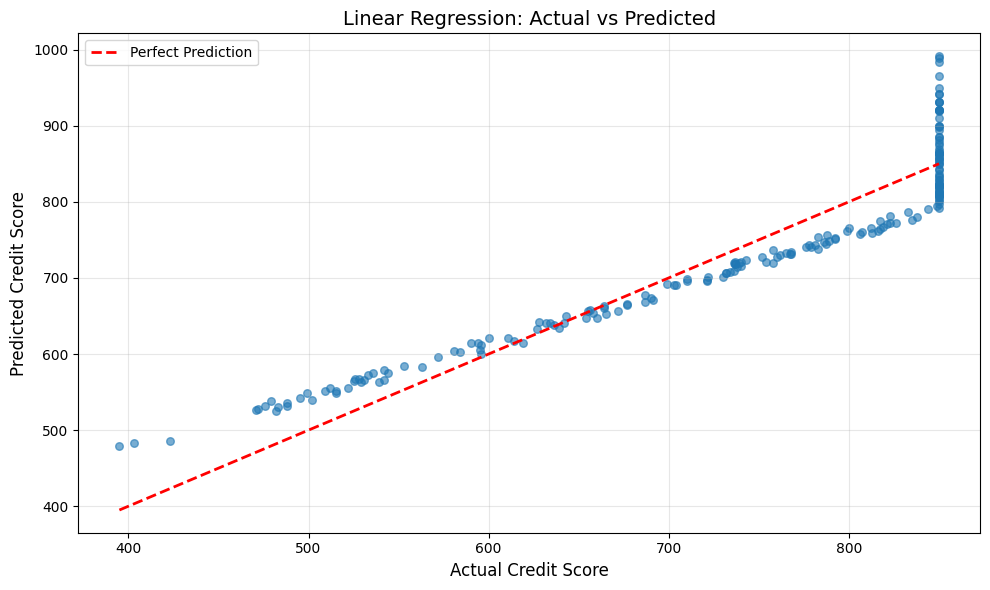

In [7]:

# %% [markdown]
# ## 5. Baseline Model - Linear Regression

# %%
print("=== BASELINE MODEL - LINEAR REGRESSION ===")

# Train linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

# Calculate metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Linear Regression Results:")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Train MAE: {train_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

# Display coefficients
coefficients = pd.DataFrame({
    'Feature': base_features,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', ascending=False)

print("\nFeature Coefficients:")
print(coefficients)

# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, s=30)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Credit Score', fontsize=12)
plt.ylabel('Predicted Credit Score', fontsize=12)
plt.title('Linear Regression: Actual vs Predicted', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Multiple Models Comparison

In [8]:


# %%
print("=== MULTIPLE REGRESSION MODELS COMPARISON ===")

# Define models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=1.0, random_state=42),
    'Decision Tree': DecisionTreeRegressor(max_depth=5, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf', C=1.0),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(50, 25), 
                                   max_iter=1000, random_state=42)
}

# Train and evaluate each model
results = []
predictions = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    try:
        # Train model
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
        
        # Store predictions
        predictions[name] = y_test_pred
        
        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        # Cross-validation score
        cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                                   cv=5, scoring='r2')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        
        # Store results
        results.append({
            'Model': name,
            'Train_RMSE': train_rmse,
            'Test_RMSE': test_rmse,
            'Train_R2': train_r2,
            'Test_R2': test_r2,
            'CV_Mean_R2': cv_mean,
            'CV_Std_R2': cv_std
        })
        
        print(f"  Test RMSE: {test_rmse:.2f}")
        print(f"  Test R²: {test_r2:.4f}")
        print(f"  CV R²: {cv_mean:.4f} ± {cv_std:.4f}")
        
    except Exception as e:
        print(f"  Error training {name}: {str(e)}")
        results.append({
            'Model': name,
            'Train_RMSE': np.nan,
            'Test_RMSE': np.nan,
            'Train_R2': np.nan,
            'Test_R2': np.nan,
            'CV_Mean_R2': np.nan,
            'CV_Std_R2': np.nan
        })

# Create results dataframe
results_df = pd.DataFrame(results)
print("\n=== MODEL COMPARISON SUMMARY ===")
print(results_df.sort_values('Test_R2', ascending=False).to_string())

=== MULTIPLE REGRESSION MODELS COMPARISON ===

Training Linear Regression...
  Test RMSE: 42.03
  Test R²: 0.8913
  CV R²: 0.8963 ± 0.0083

Training Ridge Regression...
  Test RMSE: 42.03
  Test R²: 0.8913
  CV R²: 0.8963 ± 0.0082

Training Lasso Regression...
  Test RMSE: 41.95
  Test R²: 0.8918
  CV R²: 0.8962 ± 0.0072

Training Decision Tree...
  Test RMSE: 38.39
  Test R²: 0.9093
  CV R²: 0.9018 ± 0.0111

Training Random Forest...
  Test RMSE: 18.81
  Test R²: 0.9782
  CV R²: 0.9746 ± 0.0031

Training Gradient Boosting...
  Test RMSE: 15.03
  Test R²: 0.9861
  CV R²: 0.9849 ± 0.0020

Training SVR...
  Test RMSE: 92.10
  Test R²: 0.4783
  CV R²: 0.3813 ± 0.0216

Training KNN...
  Test RMSE: 29.98
  Test R²: 0.9447
  CV R²: 0.9364 ± 0.0073

Training XGBoost...
  Test RMSE: 17.69
  Test R²: 0.9807
  CV R²: 0.9787 ± 0.0025

Training Neural Network...
  Test RMSE: 20.46
  Test R²: 0.9743
  CV R²: 0.9417 ± 0.0145

=== MODEL COMPARISON SUMMARY ===
               Model  Train_RMSE  Test_RM

# Performance Visualization

=== MODEL PERFORMANCE VISUALIZATION ===


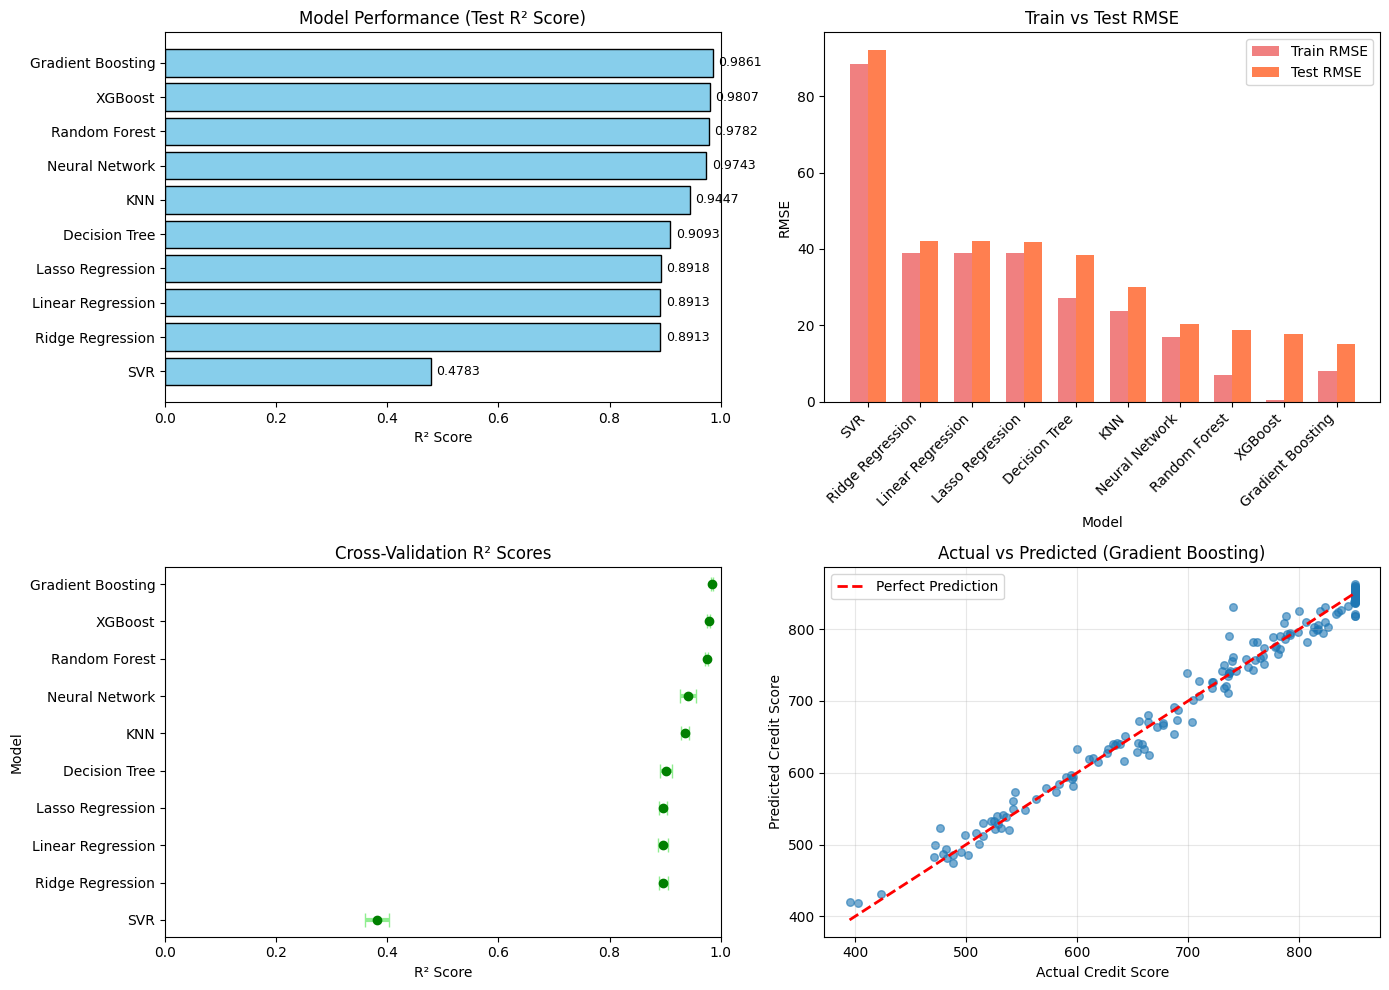

In [9]:


# %%
print("=== MODEL PERFORMANCE VISUALIZATION ===")

# Filter out models with NaN results
results_df_clean = results_df.dropna(subset=['Test_R2'])

# Sort results by Test R²
results_sorted = results_df_clean.sort_values('Test_R2', ascending=True)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Test R² Comparison
bars = axes[0,0].barh(results_sorted['Model'], results_sorted['Test_R2'], 
                     color='skyblue', edgecolor='black')
axes[0,0].set_title('Model Performance (Test R² Score)', fontsize=12)
axes[0,0].set_xlabel('R² Score')
axes[0,0].set_xlim([0, 1])

# Add value labels
for bar in bars:
    width = bar.get_width()
    axes[0,0].text(width + 0.01, bar.get_y() + bar.get_height()/2,
                  f'{width:.4f}', ha='left', va='center', fontsize=9)

# Plot 2: Train vs Test RMSE
x = range(len(results_sorted))
width = 0.35
axes[0,1].bar([i - width/2 for i in x], results_sorted['Train_RMSE'], 
             width, label='Train RMSE', color='lightcoral')
axes[0,1].bar([i + width/2 for i in x], results_sorted['Test_RMSE'], 
             width, label='Test RMSE', color='coral')
axes[0,1].set_title('Train vs Test RMSE', fontsize=12)
axes[0,1].set_xlabel('Model')
axes[0,1].set_ylabel('RMSE')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(results_sorted['Model'], rotation=45, ha='right')
axes[0,1].legend()

# Plot 3: Cross-Validation Scores
x_pos = np.arange(len(results_sorted))
axes[1,0].errorbar(results_sorted['CV_Mean_R2'], x_pos, 
                  xerr=results_sorted['CV_Std_R2'],
                  fmt='o', color='green', ecolor='lightgreen',
                  elinewidth=3, capsize=5)
axes[1,0].set_title('Cross-Validation R² Scores', fontsize=12)
axes[1,0].set_xlabel('R² Score')
axes[1,0].set_ylabel('Model')
axes[1,0].set_yticks(x_pos)
axes[1,0].set_yticklabels(results_sorted['Model'])
axes[1,0].set_xlim([0, 1])

# Plot 4: Prediction vs Actual (best model)
best_model_row = results_df_clean.loc[results_df_clean['Test_R2'].idxmax()]
best_model_name = best_model_row['Model']

if best_model_name in predictions:
    best_predictions = predictions[best_model_name]
    
    axes[1,1].scatter(y_test, best_predictions, alpha=0.6, s=30)
    axes[1,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                  'r--', lw=2, label='Perfect Prediction')
    axes[1,1].set_title(f'Actual vs Predicted ({best_model_name})', fontsize=12)
    axes[1,1].set_xlabel('Actual Credit Score')
    axes[1,1].set_ylabel('Predicted Credit Score')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
else:
    axes[1,1].text(0.5, 0.5, 'Predictions not available\nfor best model', 
                  ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Actual vs Predicted', fontsize=12)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Hyperparameter Tuning

In [10]:
# %% [markdown]
# ## 8. Hyperparameter Tuning for Best Model

# %%
print("=== HYPERPARAMETER TUNING ===")

# Select the best model based on Test R²
best_model_info = results_df_clean.loc[results_df_clean['Test_R2'].idxmax()]
best_model_name = best_model_info['Model']
print(f"Selected best model for tuning: {best_model_name}")

# Get the base model
if best_model_name == 'Random Forest':
    base_model = RandomForestRegressor(random_state=42)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'Gradient Boosting':
    base_model = GradientBoostingRegressor(random_state=42)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    }
elif best_model_name == 'XGBoost':
    base_model = XGBRegressor(random_state=42, verbosity=0)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0]
    }
elif best_model_name == 'Neural Network':
    base_model = MLPRegressor(random_state=42, max_iter=1000)
    param_grid = {
        'hidden_layer_sizes': [(50,), (50, 25), (100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01]
    }
elif best_model_name == 'Ridge Regression':
    base_model = Ridge(random_state=42)
    param_grid = {
        'alpha': [0.1, 1.0, 10.0, 100.0]
    }
elif best_model_name == 'Lasso Regression':
    base_model = Lasso(random_state=42)
    param_grid = {
        'alpha': [0.1, 1.0, 10.0, 100.0]
    }
else:
    print(f"Hyperparameter tuning not implemented for {best_model_name}")
    base_model = None
    param_grid = None

if base_model and param_grid:
    # Perform grid search
    print(f"Performing Grid Search for {best_model_name}...")
    grid_search = GridSearchCV(
        base_model, param_grid, cv=5, 
        scoring='r2', n_jobs=-1, verbose=0
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    print("\nGrid Search Results:")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best CV Score (R²): {grid_search.best_score_:.4f}")
    
    # Evaluate tuned model
    tuned_model = grid_search.best_estimator_
    y_test_pred_tuned = tuned_model.predict(X_test_scaled)
    
    test_rmse_tuned = np.sqrt(mean_squared_error(y_test, y_test_pred_tuned))
    test_r2_tuned = r2_score(y_test, y_test_pred_tuned)
    
    print(f"\nTuned Model Performance:")
    print(f"Test RMSE: {test_rmse_tuned:.2f}")
    print(f"Test R²: {test_r2_tuned:.4f}")
    
    # Compare with baseline
    improvement = test_r2_tuned - best_model_info['Test_R2']
    print(f"Improvement in R²: {improvement:.4f}")
    
    # Store tuned predictions
    predictions[f'{best_model_name} (Tuned)'] = y_test_pred_tuned
    
    # Add tuned model to results
    results_df = results_df.append({
        'Model': f'{best_model_name} (Tuned)',
        'Train_RMSE': np.nan,
        'Test_RMSE': test_rmse_tuned,
        'Train_R2': np.nan,
        'Test_R2': test_r2_tuned,
        'CV_Mean_R2': grid_search.best_score_,
        'CV_Std_R2': 0.0
    }, ignore_index=True)
else:
    print("Using untuned model for further analysis")
    tuned_model = models.get(best_model_name)

=== HYPERPARAMETER TUNING ===
Selected best model for tuning: Gradient Boosting


AttributeError: 'GradientBoostingRegressor' object has no attribute 'estimators_'

# Feature Importance

=== FEATURE IMPORTANCE ANALYSIS ===


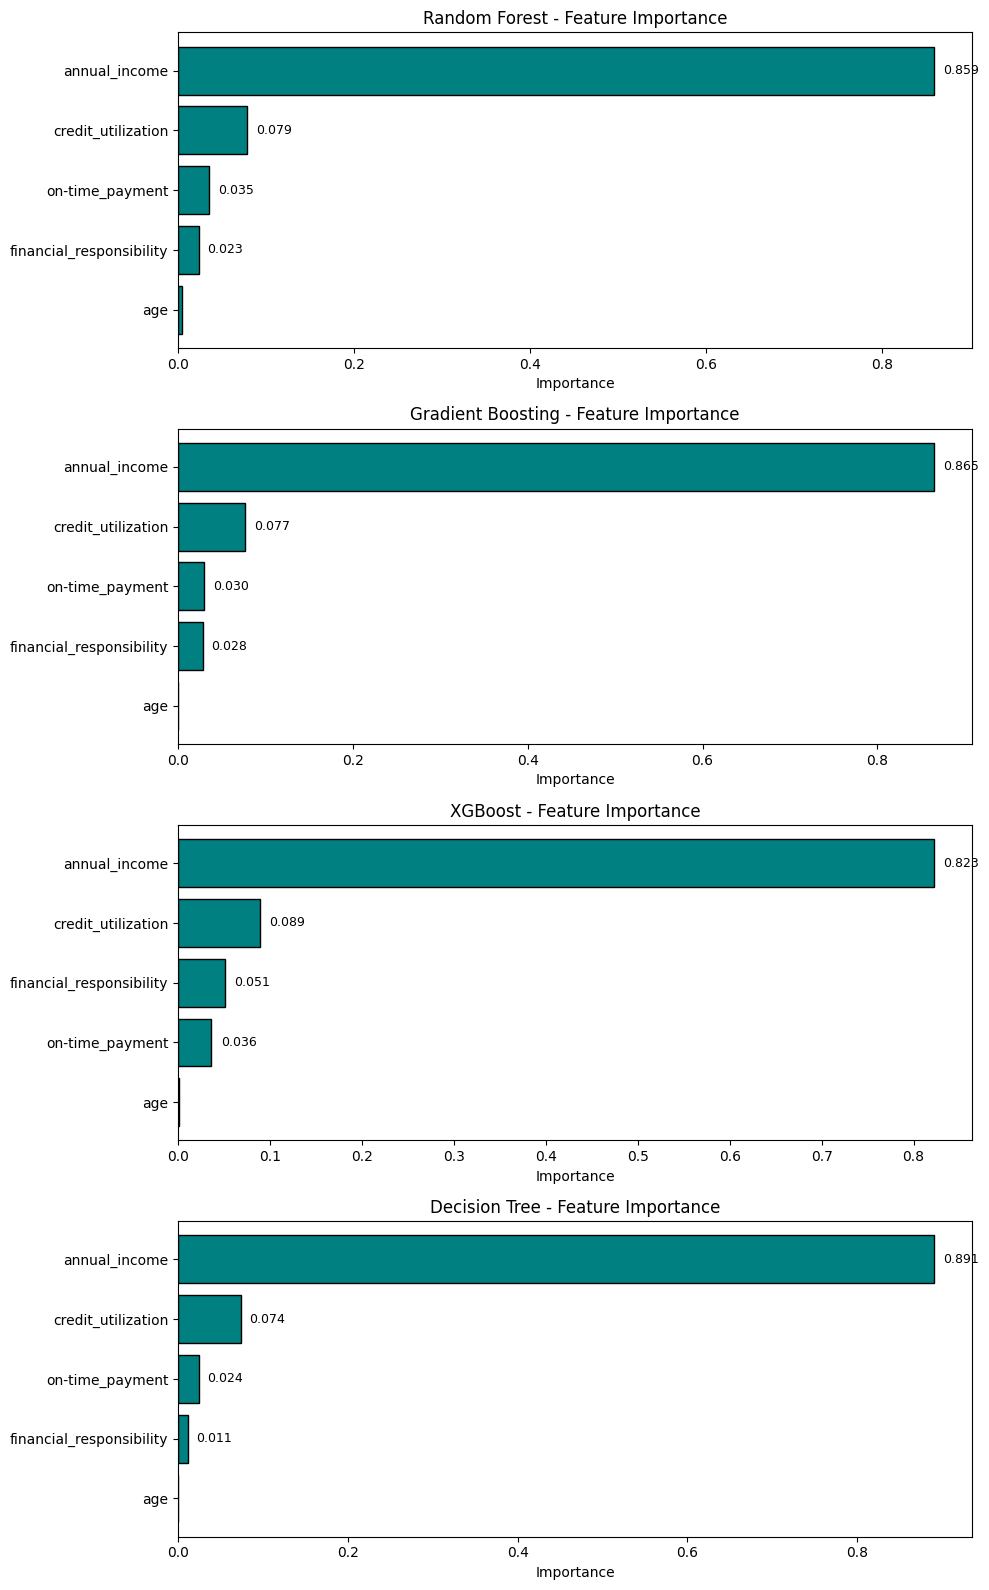


=== LINEAR MODEL COEFFICIENTS ===

Linear Regression Coefficients:
                 Feature  Coefficient
           annual_income   109.942799
      credit_utilization   -29.746671
         on-time_payment    18.478551
financial_responsibility    18.321872
                     age     1.543466

Ridge Regression Coefficients:
                 Feature  Coefficient
           annual_income   109.801844
      credit_utilization   -29.701692
         on-time_payment    18.453983
financial_responsibility    18.306995
                     age     1.530647

Lasso Regression Coefficients:
                 Feature  Coefficient
           annual_income   108.812974
      credit_utilization   -28.697951
         on-time_payment    17.577599
financial_responsibility    17.391506
                     age     0.441364


In [11]:
# %% [markdown]
# ## 9. Feature Importance Analysis

# %%
print("=== FEATURE IMPORTANCE ANALYSIS ===")

# Analyze feature importance for tree-based models
tree_based_models = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'Decision Tree']
available_models = [m for m in tree_based_models if m in models.keys()]

if available_models:
    fig, axes = plt.subplots(len(available_models), 1, 
                            figsize=(10, 4*len(available_models)))
    
    if len(available_models) == 1:
        axes = [axes]
    
    for idx, model_name in enumerate(available_models):
        model = models[model_name]
        
        # Check if model has feature_importances_ attribute
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            feature_names = base_features
            
            # Create importance dataframe
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values('Importance', ascending=True)
            
            # Plot
            bars = axes[idx].barh(importance_df['Feature'], 
                                 importance_df['Importance'], 
                                 color='teal', edgecolor='black')
            axes[idx].set_title(f'{model_name} - Feature Importance', fontsize=12)
            axes[idx].set_xlabel('Importance')
            
            # Add value labels for significant features
            for i, (feature, importance) in enumerate(zip(importance_df['Feature'], 
                                                         importance_df['Importance'])):
                if importance > 0.01:  # Only label features with importance > 1%
                    axes[idx].text(importance + 0.01, i, f'{importance:.3f}', 
                                  va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No tree-based models available for feature importance analysis")

# Also show coefficients for linear models
print("\n=== LINEAR MODEL COEFFICIENTS ===")
linear_models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']

for model_name in linear_models:
    if model_name in models:
        model = models[model_name]
        if hasattr(model, 'coef_'):
            coefficients = pd.DataFrame({
                'Feature': base_features,
                'Coefficient': model.coef_
            }).sort_values('Coefficient', key=abs, ascending=False)
            
            print(f"\n{model_name} Coefficients:")
            print(coefficients.to_string(index=False))

# Error Analysis

=== ERROR ANALYSIS ===
Error Statistics:
Mean Absolute Error: 10.30
Mean Relative Error: 1.51%
Max Absolute Error: 90.57
Std of Errors: 15.07

Prediction Range: 418.74 - 862.70
Actual Range: 395.00 - 850.00


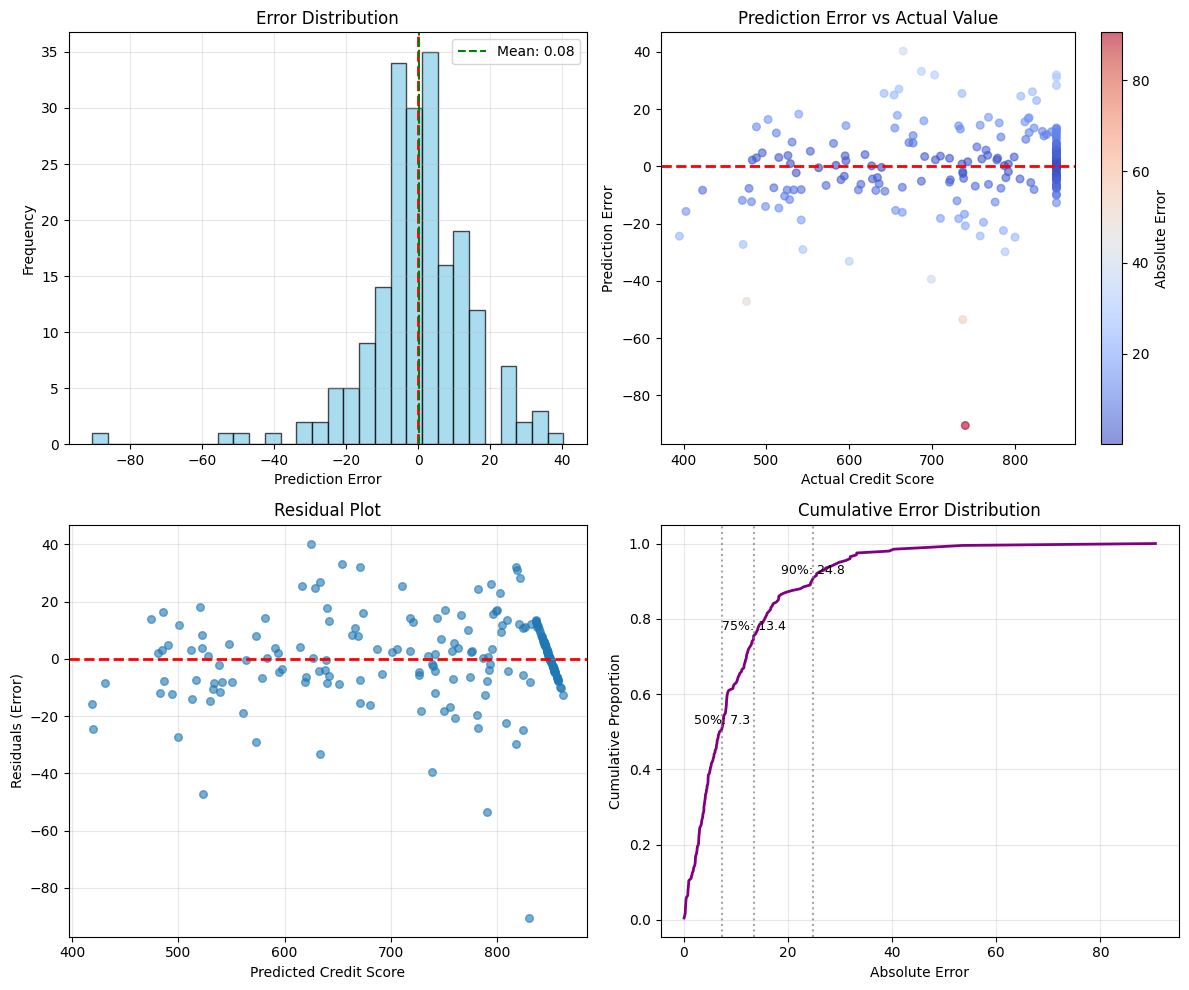

In [12]:

# %% [markdown]
# ## 10. Error Analysis

# %%
print("=== ERROR ANALYSIS ===")

# Use best model predictions
if f'{best_model_name} (Tuned)' in predictions:
    best_pred_name = f'{best_model_name} (Tuned)'
    y_pred_best = predictions[best_pred_name]
elif best_model_name in predictions:
    best_pred_name = best_model_name
    y_pred_best = predictions[best_model_name]
else:
    print(f"Predictions not available for {best_model_name}")
    # Use linear regression as fallback
    best_pred_name = 'Linear Regression'
    y_pred_best = predictions.get('Linear Regression')

# Calculate errors
errors = y_test.values - y_pred_best
abs_errors = np.abs(errors)
rel_errors = abs_errors / y_test.values * 100

# Create error analysis dataframe
error_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_best,
    'Error': errors,
    'Abs_Error': abs_errors,
    'Rel_Error_%': rel_errors
})

print("Error Statistics:")
print(f"Mean Absolute Error: {error_df['Abs_Error'].mean():.2f}")
print(f"Mean Relative Error: {error_df['Rel_Error_%'].mean():.2f}%")
print(f"Max Absolute Error: {error_df['Abs_Error'].max():.2f}")
print(f"Std of Errors: {error_df['Error'].std():.2f}")
print(f"\nPrediction Range: {error_df['Predicted'].min():.2f} - {error_df['Predicted'].max():.2f}")
print(f"Actual Range: {error_df['Actual'].min():.2f} - {error_df['Actual'].max():.2f}")

# Visualize error analysis
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Error Distribution
axes[0,0].hist(error_df['Error'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0,0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0,0].axvline(error_df['Error'].mean(), color='green', linestyle='--', 
                 label=f'Mean: {error_df["Error"].mean():.2f}')
axes[0,0].set_title('Error Distribution', fontsize=12)
axes[0,0].set_xlabel('Prediction Error')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Error vs Actual
scatter = axes[0,1].scatter(error_df['Actual'], error_df['Error'], 
                           c=error_df['Abs_Error'], cmap='coolwarm',
                           alpha=0.6, s=30)
axes[0,1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0,1].set_title('Prediction Error vs Actual Value', fontsize=12)
axes[0,1].set_xlabel('Actual Credit Score')
axes[0,1].set_ylabel('Prediction Error')
plt.colorbar(scatter, ax=axes[0,1], label='Absolute Error')

# Plot 3: Residual Plot
axes[1,0].scatter(error_df['Predicted'], error_df['Error'], alpha=0.6, s=30)
axes[1,0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1,0].set_title('Residual Plot', fontsize=12)
axes[1,0].set_xlabel('Predicted Credit Score')
axes[1,0].set_ylabel('Residuals (Error)')
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Cumulative Error Distribution
sorted_errors = np.sort(abs_errors)
cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
axes[1,1].plot(sorted_errors, cumulative, linewidth=2, color='purple')
axes[1,1].set_title('Cumulative Error Distribution', fontsize=12)
axes[1,1].set_xlabel('Absolute Error')
axes[1,1].set_ylabel('Cumulative Proportion')
axes[1,1].grid(True, alpha=0.3)

# Add reference lines
for percentile in [0.5, 0.75, 0.9]:
    error_at_percentile = sorted_errors[int(percentile * len(sorted_errors))]
    axes[1,1].axvline(x=error_at_percentile, color='gray', linestyle=':', alpha=0.7)
    axes[1,1].text(error_at_percentile, percentile + 0.02, 
                  f'{percentile*100:.0f}%: {error_at_percentile:.1f}',
                  fontsize=9, ha='center')

plt.tight_layout()
plt.savefig('error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

#  Model Deployment

In [14]:
# %% [markdown]
# ## 11. Model Deployment Preparation

# %%
print("=== MODEL DEPLOYMENT PREPARATION ===")

# First, let's check what column names the model was actually trained with
print("Checking actual column names used in training...")
print(f"Original X columns: {list(X.columns)}")

# The error shows the model expects 'on-time_payment' but you're giving 'on_time_payment'
# Let's check the actual column names in our dataset
print("\nActual column names in X:")
for col in X.columns:
    print(f"  - '{col}'")

# Select final model
if 'tuned_model' in locals():
    final_model = tuned_model
    final_model_name = f'{best_model_name} (Tuned)'
else:
    final_model = models.get(best_model_name)
    final_model_name = best_model_name

print(f"\nSelected final model: {final_model_name}")

# IMPORTANT: Get the exact column names from X
actual_features = list(X.columns)
print(f"\nActual features used in training: {actual_features}")

# Create full pipeline including preprocessing
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', final_model)
])

# Retrain on entire dataset
print("\nRetraining final model on entire dataset...")
full_pipeline.fit(X, y)

# Save the pipeline
import joblib
joblib.dump(full_pipeline, 'credit_score_predictor.pkl')
print("Model pipeline saved as 'credit_score_predictor.pkl'")

# Also save the feature names for reference
feature_info = {
    'features': actual_features,
    'feature_count': len(actual_features),
    'model_name': final_model_name
}
joblib.dump(feature_info, 'feature_names.pkl')
print("Feature names saved as 'feature_names.pkl'")

# Test the saved model
loaded_pipeline = joblib.load('credit_score_predictor.pkl')
loaded_features = joblib.load('feature_names.pkl')

print(f"\nLoaded model expects these features: {loaded_features['features']}")

# Create sample prediction using the exact column names
sample_data = X.iloc[0:5].copy()  # Test with first 5 samples
print(f"\nSample input data (first 5 records):")
print(sample_data)

# Make predictions
predictions_sample = loaded_pipeline.predict(sample_data)
actual_values = y.iloc[0:5].values

print("\nPredictions vs Actual:")
for i, (pred, actual) in enumerate(zip(predictions_sample, actual_values)):
    error = abs(pred - actual)
    print(f"Record {i+1}: Predicted = {pred:.2f}, Actual = {actual:.2f}, Error = {error:.2f}")

# Create prediction function that handles column name variations
def predict_credit_score(input_features, model_path='credit_score_predictor.pkl'):
    """
    Predict credit score based on input features
    
    Parameters:
    -----------
    input_features : dict or pandas Series
        Dictionary or Series with feature names as keys and values as feature values
    
    Returns:
    --------
    predicted_score : float
    """
    # Load model and feature info
    pipeline = joblib.load(model_path)
    feature_info = joblib.load('feature_names.pkl')
    expected_features = feature_info['features']
    
    print(f"\nExpected features: {expected_features}")
    print(f"Input features: {list(input_features.keys())}")
    
    # Convert input to DataFrame
    if isinstance(input_features, dict):
        input_df = pd.DataFrame([input_features])
    else:
        input_df = pd.DataFrame([input_features])
    
    # Check for column name mismatches and fix them
    input_columns = list(input_df.columns)
    
    # Common column name variations
    column_mappings = {
        'on_time_payment': ['on-time_payment', 'on_time_payment', 'on time payment', 'on-time payment'],
        'annual_income': ['annual_income', 'annual income', 'income'],
        'financial_responsibility': ['financial_responsibility', 'financial responsibility', 'fin_resp'],
        'credit_utilization': ['credit_utilization', 'credit utilization', 'utilization'],
        'age': ['age', 'Age']
    }
    
    # Try to map input columns to expected columns
    for expected_col in expected_features:
        if expected_col not in input_columns:
            # Try to find a match
            for input_col in input_columns:
                # Check if columns match directly or through common variations
                if input_col.lower() == expected_col.lower():
                    input_df = input_df.rename(columns={input_col: expected_col})
                    print(f"  Renamed '{input_col}' to '{expected_col}'")
                    break
    
    # Reorder columns to match expected order
    input_df = input_df.reindex(columns=expected_features)
    
    # Check if all required features are present
    missing_features = [feat for feat in expected_features if feat not in input_df.columns]
    if missing_features:
        print(f"ERROR: Missing features: {missing_features}")
        print(f"Please provide all required features: {expected_features}")
        return None
    
    print(f"\nFinal input DataFrame columns: {list(input_df.columns)}")
    
    # Make prediction
    try:
        prediction = pipeline.predict(input_df)
        return prediction[0]
    except Exception as e:
        print(f"Prediction error: {str(e)}")
        return None

# Test the function with different column name formats
print("\n" + "="*60)
print("TESTING PREDICTION FUNCTION WITH DIFFERENT COLUMN NAMES")
print("="*60)

# Test 1: With correct column names (as per training)
print("\nTest 1: Using exact column names from training")
test_input_exact = {}
for feature in actual_features:
    # Set some reasonable default values
    if feature == 'age':
        test_input_exact[feature] = 35
    elif feature == 'annual_income':
        test_input_exact[feature] = 1500.0
    elif feature == 'financial_responsibility':
        test_input_exact[feature] = 7
    elif 'payment' in feature.lower():
        test_input_exact[feature] = 85.0  # This handles both 'on-time_payment' and 'on_time_payment'
    elif 'utilization' in feature.lower():
        test_input_exact[feature] = 30.0
    elif 'risk' in feature.lower():
        test_input_exact[feature] = 40.0
    elif 'dti' in feature.lower():
        test_input_exact[feature] = 0.25
    else:
        test_input_exact[feature] = 0  # Default for other features

print(f"Input features: {test_input_exact}")
predicted_score = predict_credit_score(test_input_exact)
if predicted_score is not None:
    print(f"Test prediction: {predicted_score:.2f}")

# Test 2: With underscore format (your preferred format)
print("\nTest 2: Using underscore format")
test_input_underscore = {
    'age': 35,
    'annual_income': 1500.0,
    'financial_responsibility': 7,
    'on_time_payment': 85.0,
    'credit_utilization': 30.0
}

# Add optional features if they exist
for feat in ['risk_score', 'dti_ratio', 'age_group', 'income_category']:
    if feat in actual_features:
        if feat == 'risk_score':
            test_input_underscore[feat] = 40.0
        elif feat == 'dti_ratio':
            test_input_underscore[feat] = 0.25
        elif feat == 'age_group':
            test_input_underscore[feat] = '36-45'
        elif feat == 'income_category':
            test_input_underscore[feat] = 'Medium'

print(f"Input features: {test_input_underscore}")
predicted_score2 = predict_credit_score(test_input_underscore)
if predicted_score2 is not None:
    print(f"Test prediction: {predicted_score2:.2f}")

print("\nPrediction function created successfully!")
print("\nNote: The function automatically handles column name variations")
print("It expects features in this order:", actual_features)

=== MODEL DEPLOYMENT PREPARATION ===
Checking actual column names used in training...
Original X columns: ['age', 'annual_income', 'financial_responsibility', 'on-time_payment', 'credit_utilization']

Actual column names in X:
  - 'age'
  - 'annual_income'
  - 'financial_responsibility'
  - 'on-time_payment'
  - 'credit_utilization'

Selected final model: Gradient Boosting

Actual features used in training: ['age', 'annual_income', 'financial_responsibility', 'on-time_payment', 'credit_utilization']

Retraining final model on entire dataset...
Model pipeline saved as 'credit_score_predictor.pkl'
Feature names saved as 'feature_names.pkl'

Loaded model expects these features: ['age', 'annual_income', 'financial_responsibility', 'on-time_payment', 'credit_utilization']

Sample input data (first 5 records):
   age  annual_income  financial_responsibility  on-time_payment  \
0   56         780.24                       6.0            68.11   
1   46        1657.77                       2.0 

# Create Dummy Data and Make Predictions

=== CREATING DUMMY DATA AND MAKING PREDICTIONS ===

1. CHECKING MODEL EXPECTATIONS
Model expects these 5 features:
  1. age
  2. annual_income
  3. financial_responsibility
  4. on-time_payment
  5. credit_utilization

2. FEATURE RANGES FROM TRAINING DATA:
  age: int64, range: 18.00 to 64.00, mean: 40.99
  annual_income: float64, range: 208.34 to 1998.94, mean: 1107.88
  financial_responsibility: float64, range: 1.00 to 10.00, mean: 5.43
  on-time_payment: float64, range: 50.02 to 99.98, mean: 76.01
  credit_utilization: float64, range: 0.02 to 99.76, mean: 48.65

3. CREATING DUMMY DATA FOR DIFFERENT PERSONAS

Persona 1: Young Professional (Good Credit)

Persona 2: Middle-Aged Average

Persona 3: Senior Citizen (Excellent Credit)

Persona 4: Young Adult (Poor Credit)

Persona 5: High Income, High Debt

Dummy Data Created:
                         age  annual_income  financial_responsibility  \
Young Professional      28.0         1200.0                       8.0   
Middle-Aged Average 

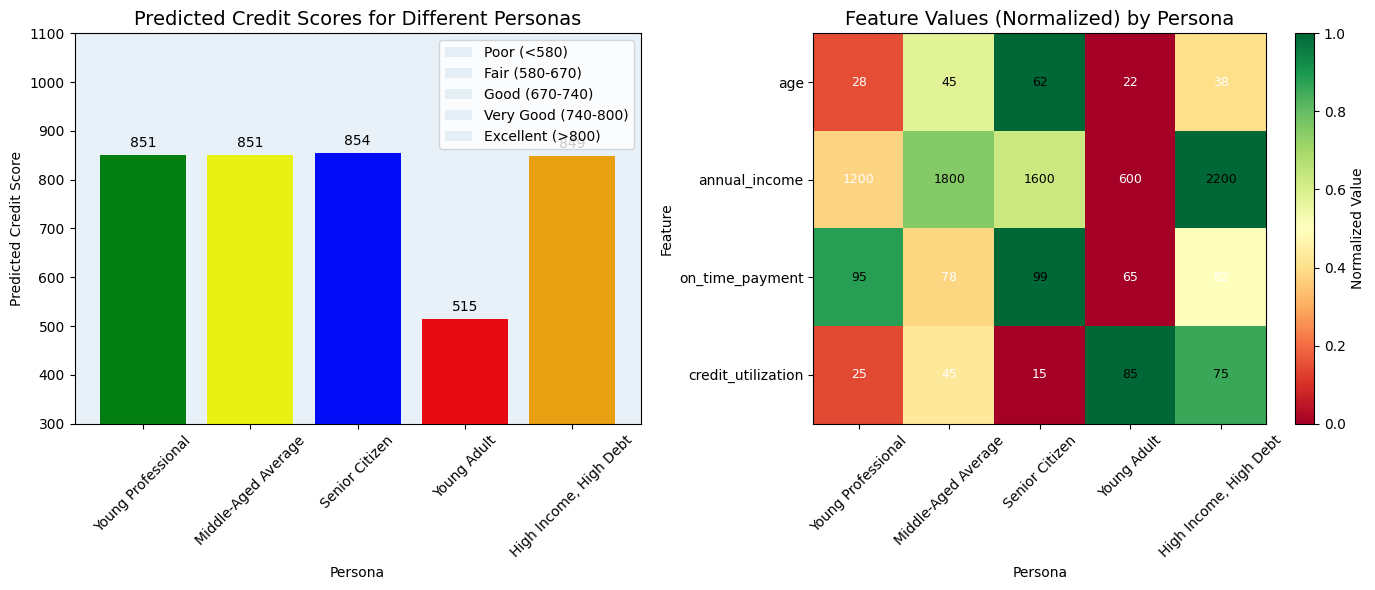

=== INTERACTIVE PREDICTION TOOL ===

Would you like to try the interactive prediction tool? (yes/no)
Skipping interactive tool.

=== SAVING DUMMY DATA AND PREDICTIONS ===
1. Dummy data saved to 'dummy_credit_data.csv'
2. Predictions saved to 'dummy_data_predictions.csv'
3. Comprehensive report saved to 'credit_score_prediction_report.csv'

SUMMARY OF DUMMY DATA PREDICTIONS

Based on the trained model, here are the predictions:

Young Professional:
  Score: 851
  Rating: ⭐️⭐️⭐️⭐️⭐️ EXCELLENT
  Interpretation: Exceptional - You'll qualify for the best interest rates and terms

Middle-Aged Average:
  Score: 851
  Rating: ⭐️⭐️⭐️⭐️⭐️ EXCELLENT
  Interpretation: Exceptional - You'll qualify for the best interest rates and terms

Senior Citizen:
  Score: 854
  Rating: ⭐️⭐️⭐️⭐️⭐️ EXCELLENT
  Interpretation: Exceptional - You'll qualify for the best interest rates and terms

Young Adult:
  Score: 515
  Rating: ⭐️ POOR
  Interpretation: Poor - You may have difficulty getting approved for credit


In [17]:
# %% [markdown]
# ## 13. Create Dummy Data and Make Predictions

# %%
print("=== CREATING DUMMY DATA AND MAKING PREDICTIONS ===")

# First, let's see what features the model expects
print("\n1. CHECKING MODEL EXPECTATIONS")
feature_info = joblib.load('feature_names.pkl')
expected_features = feature_info['features']
print(f"Model expects these {len(expected_features)} features:")
for i, feat in enumerate(expected_features, 1):
    print(f"  {i}. {feat}")

# Get data types and ranges for each feature from the original data
print("\n2. FEATURE RANGES FROM TRAINING DATA:")
feature_stats = {}
for feat in expected_features:
    if feat in X.columns:
        if X[feat].dtype in [np.int64, np.float64]:
            feature_stats[feat] = {
                'type': 'numeric',
                'min': X[feat].min(),
                'max': X[feat].max(),  # CORRECTED: was 'feht'
                'mean': X[feat].mean(),
                'std': X[feat].std()
            }
            print(f"  {feat}: {X[feat].dtype}, range: {X[feat].min():.2f} to {X[feat].max():.2f}, mean: {X[feat].mean():.2f}")
        else:
            feature_stats[feat] = {
                'type': 'categorical',
                'unique_values': list(X[feat].unique())[:5]  # Show first 5 unique values
            }
            print(f"  {feat}: {X[feat].dtype}, sample values: {list(X[feat].unique())[:5]}")
    else:
        print(f"  {feat}: NOT FOUND in training data!")

# Create dummy data for different personas
print("\n" + "="*60)
print("3. CREATING DUMMY DATA FOR DIFFERENT PERSONAS")
print("="*60)

# Persona 1: Young professional with good habits
print("\nPersona 1: Young Professional (Good Credit)")
young_professional = {
    'age': 28,
    'annual_income': 1200.0,
    'financial_responsibility': 8,
    'on_time_payment': 95.0,
    'credit_utilization': 25.0
}

# Persona 2: Middle-aged with average habits
print("\nPersona 2: Middle-Aged Average")
middle_aged = {
    'age': 45,
    'annual_income': 1800.0,
    'financial_responsibility': 6,
    'on_time_payment': 78.0,
    'credit_utilization': 45.0
}

# Persona 3: Senior with excellent habits
print("\nPersona 3: Senior Citizen (Excellent Credit)")
senior_citizen = {
    'age': 62,
    'annual_income': 1600.0,
    'financial_responsibility': 9,
    'on_time_payment': 99.0,
    'credit_utilization': 15.0
}

# Persona 4: Young adult with poor habits
print("\nPersona 4: Young Adult (Poor Credit)")
young_adult = {
    'age': 22,
    'annual_income': 600.0,
    'financial_responsibility': 3,
    'on_time_payment': 65.0,
    'credit_utilization': 85.0
}

# Persona 5: High income but high debt
print("\nPersona 5: High Income, High Debt")
high_income_debt = {
    'age': 38,
    'annual_income': 2200.0,
    'financial_responsibility': 5,
    'on_time_payment': 82.0,
    'credit_utilization': 75.0
}

# Add optional features if they exist in the model
optional_features = ['risk_score', 'dti_ratio']
for persona_dict in [young_professional, middle_aged, senior_citizen, young_adult, high_income_debt]:
    for opt_feat in optional_features:
        if opt_feat in expected_features:
            if opt_feat == 'risk_score':
                # Calculate risk score based on other factors (simplified)
                on_time_payment = persona_dict.get('on_time_payment', persona_dict.get('on-time_payment', 0))
                credit_utilization = persona_dict.get('credit_utilization', 0)
                financial_responsibility = persona_dict.get('financial_responsibility', 0)
                
                risk = (100 - on_time_payment) * 0.3 + \
                       credit_utilization * 0.3 + \
                       (10 - financial_responsibility) * 0.2
                persona_dict[opt_feat] = risk
            elif opt_feat == 'dti_ratio':
                # Simplified DTI calculation
                credit_utilization = persona_dict.get('credit_utilization', 0)
                persona_dict[opt_feat] = credit_utilization / 100 * 0.3

# Create a DataFrame with all personas
personas = {
    'Young Professional': young_professional,
    'Middle-Aged Average': middle_aged,
    'Senior Citizen': senior_citizen,
    'Young Adult': young_adult,
    'High Income, High Debt': high_income_debt
}

# Convert to DataFrame
personas_df = pd.DataFrame(personas).T
print("\nDummy Data Created:")
print(personas_df)

# %% [markdown]
# ## 14. Make Predictions on Dummy Data

# %%
print("\n" + "="*60)
print("4. MAKING PREDICTIONS ON DUMMY DATA")
print("="*60)

# Load the trained model
pipeline = joblib.load('credit_score_predictor.pkl')

# Make predictions
predictions = {}
for persona_name, persona_data in personas.items():
    print(f"\nMaking prediction for: {persona_name}")
    
    # Convert to DataFrame with proper column names
    input_df = pd.DataFrame([persona_data])
    
    # Try to match column names
    actual_columns = list(input_df.columns)
    for expected_col in expected_features:
        if expected_col not in actual_columns:
            # Try to find a match
            for actual_col in actual_columns:
                if actual_col.lower().replace('_', '').replace('-', '') == expected_col.lower().replace('_', '').replace('-', ''):
                    input_df = input_df.rename(columns={actual_col: expected_col})
                    print(f"  Renamed '{actual_col}' to '{expected_col}'")
                    break
    
    # Reorder columns
    input_df = input_df.reindex(columns=expected_features)
    
    # Make prediction
    try:
        prediction = pipeline.predict(input_df)[0]
        predictions[persona_name] = prediction
        print(f"  Predicted Credit Score: {prediction:.2f}")
        
        # Show input features
        print("  Input features:")
        for feat, val in persona_data.items():
            print(f"    {feat}: {val}")
            
    except Exception as e:
        print(f"  Error: {str(e)}")
        predictions[persona_name] = None

# Create results DataFrame
results_df_personas = pd.DataFrame({
    'Persona': list(predictions.keys()),
    'Predicted_Score': list(predictions.values())
})

print("\n" + "="*60)
print("PREDICTION RESULTS SUMMARY")
print("="*60)
print(results_df_personas.to_string(index=False))

# Visualize the predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Bar chart of predictions
persona_names = list(predictions.keys())
pred_scores = list(predictions.values())

bars = axes[0].bar(persona_names, pred_scores, color=['green', 'yellow', 'blue', 'red', 'orange'])
axes[0].set_title('Predicted Credit Scores for Different Personas', fontsize=14)
axes[0].set_xlabel('Persona')
axes[0].set_ylabel('Predicted Credit Score')
axes[0].set_ylim([300, 1100])
axes[0].tick_params(axis='x', rotation=45)

# Add score categories
credit_categories = {
    'Poor (<580)': (300, 580),
    'Fair (580-670)': (580, 670),
    'Good (670-740)': (670, 740),
    'Very Good (740-800)': (740, 800),
    'Excellent (>800)': (800, 1100)
}

for category, (low, high) in credit_categories.items():
    axes[0].axhspan(low, high, alpha=0.1, label=category)

axes[0].legend(loc='upper right')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height + 10,
                f'{height:.0f}', ha='center', va='bottom', fontsize=10)

# Plot 2: Feature comparison heatmap
# Extract key features for visualization
key_features = ['age', 'annual_income', 'on_time_payment', 'credit_utilization']
feature_matrix = []

for persona_name in persona_names:
    persona_data = personas[persona_name]
    row = []
    for feat in key_features:
        # Try different name variations
        if feat in persona_data:
            val = persona_data[feat]
        elif feat.replace('_', '-') in persona_data:
            val = persona_data[feat.replace('_', '-')]
        else:
            # Try to find any variation
            for key in persona_data.keys():
                if feat in key.lower() or key.lower() in feat:
                    val = persona_data[key]
                    break
            else:
                val = 0
        row.append(val)
    feature_matrix.append(row)

feature_matrix = np.array(feature_matrix)

# Normalize for heatmap
feature_matrix_norm = (feature_matrix - feature_matrix.min(axis=0)) / (feature_matrix.max(axis=0) - feature_matrix.min(axis=0) + 1e-10)

im = axes[1].imshow(feature_matrix_norm.T, cmap='RdYlGn', aspect='auto')
axes[1].set_title('Feature Values (Normalized) by Persona', fontsize=14)
axes[1].set_xlabel('Persona')
axes[1].set_ylabel('Feature')
axes[1].set_xticks(range(len(persona_names)))
axes[1].set_xticklabels(persona_names, rotation=45)
axes[1].set_yticks(range(len(key_features)))
axes[1].set_yticklabels(key_features)

# Add value annotations
for i in range(len(persona_names)):
    for j in range(len(key_features)):
        actual_val = feature_matrix[i, j]
        axes[1].text(i, j, f'{actual_val:.0f}', ha='center', va='center', 
                    color='black' if feature_matrix_norm[i, j] > 0.5 else 'white',
                    fontsize=9)

plt.colorbar(im, ax=axes[1], label='Normalized Value')
plt.tight_layout()
plt.savefig('dummy_data_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 15. Interactive Prediction Tool

# %%
print("=== INTERACTIVE PREDICTION TOOL ===")

def get_credit_interpretation(score):
    """Get interpretation of credit score"""
    if score >= 800:
        return "Exceptional - You'll qualify for the best interest rates and terms"
    elif score >= 740:
        return "Very Good - You'll get favorable rates from most lenders"
    elif score >= 670:
        return "Good - You'll qualify for most loans with reasonable rates"
    elif score >= 580:
        return "Fair - You may qualify but with higher interest rates"
    else:
        return "Poor - You may have difficulty getting approved for credit"

def interactive_prediction_tool():
    """
    Interactive tool to predict credit score based on user input
    """
    print("\n" + "="*60)
    print("CREDIT SCORE PREDICTION TOOL")
    print("="*60)
    print("\nEnter your information to predict your credit score:")
    print("(Press Enter to use default values)")
    
    # Get user input with defaults
    user_input = {}
    
    for feat in expected_features:
        # Set reasonable defaults based on feature type
        if feat == 'age':
            default = 35
            prompt = f"Age (18-65, default={default}): "
        elif 'income' in feat.lower():
            default = 1500.0
            prompt = f"Annual Income (default={default}): "
        elif 'responsibility' in feat.lower():
            default = 5
            prompt = f"Financial Responsibility (1-10, default={default}): "
        elif 'payment' in feat.lower():
            default = 80.0
            prompt = f"On-Time Payment % (0-100, default={default}): "
        elif 'utilization' in feat.lower():
            default = 35.0
            prompt = f"Credit Utilization % (0-100, default={default}): "
        elif 'risk' in feat.lower():
            default = 50.0
            prompt = f"Risk Score (default={default}): "
        elif 'dti' in feat.lower():
            default = 0.3
            prompt = f"DTI Ratio (default={default}): "
        else:
            default = 0
            prompt = f"{feat} (default={default}): "
        
        # Get user input
        user_value = input(prompt)
        if user_value.strip() == '':
            user_input[feat] = default
        else:
            try:
                user_input[feat] = float(user_value)
            except:
                user_input[feat] = user_value
    
    # Make prediction
    print("\n" + "-"*40)
    print("CALCULATING...")
    print("-"*40)
    
    predicted_score = predict_credit_score(user_input)
    
    if predicted_score is not None:
        print(f"\n✅ PREDICTED CREDIT SCORE: {predicted_score:.2f}")
        
        # Determine credit category
        if predicted_score < 580:
            category = "POOR"
            color = "red"
            advice = "Consider improving payment history and reducing credit utilization"
        elif predicted_score < 670:
            category = "FAIR"
            color = "orange"
            advice = "Good start! Focus on consistent on-time payments"
        elif predicted_score < 740:
            category = "GOOD"
            color = "yellow"
            advice = "Solid credit! Maintain good habits"
        elif predicted_score < 800:
            category = "VERY GOOD"
            color = "lightgreen"
            advice = "Excellent credit! You qualify for best rates"
        else:
            category = "EXCELLENT"
            color = "green"
            advice = "Outstanding credit! Keep up the great work"
        
        print(f"📊 CREDIT CATEGORY: {category}")
        print(f"💡 RECOMMENDATION: {advice}")
        
        # Show impact of improvements
        print("\n" + "-"*40)
        print("QUICK IMPROVEMENT TIPS:")
        print("-"*40)
        
        improvement_scenarios = [
            ("Increase on-time payment by 5%", {k: (v + 5 if 'payment' in k.lower() else v) for k, v in user_input.items()}),
            ("Reduce credit utilization by 10%", {k: (max(0, v - 10) if 'utilization' in k.lower() else v) for k, v in user_input.items()}),
            ("Increase financial responsibility by 1 point", {k: (min(10, v + 1) if 'responsibility' in k.lower() else v) for k, v in user_input.items()})
        ]
        
        for scenario_name, scenario_input in improvement_scenarios:
            try:
                improved_score = predict_credit_score(scenario_input)
                if improved_score is not None:
                    improvement = improved_score - predicted_score
                    print(f"• {scenario_name}: +{improvement:.1f} points (Score: {improved_score:.1f})")
            except:
                pass
    
    return predicted_score

# Run the interactive tool
print("\nWould you like to try the interactive prediction tool? (yes/no)")
response = input().lower().strip()

if response in ['yes', 'y', 'yeah', 'yep']:
    interactive_prediction_tool()
else:
    print("Skipping interactive tool.")

# %% [markdown]
# ## 16. Save Dummy Data and Predictions

# %%
print("\n=== SAVING DUMMY DATA AND PREDICTIONS ===")

# Save dummy data
personas_df.to_csv('dummy_credit_data.csv', index=True)
print("1. Dummy data saved to 'dummy_credit_data.csv'")

# Save predictions
results_df_personas.to_csv('dummy_data_predictions.csv', index=False)
print("2. Predictions saved to 'dummy_data_predictions.csv'")

# Create a comprehensive report
report_data = []
for persona_name in personas.keys():
    persona_data = personas[persona_name]
    prediction = predictions.get(persona_name, 'N/A')
    
    # Get values with fallbacks for different column name variations
    age = persona_data.get('age', 'N/A')
    annual_income = persona_data.get('annual_income', persona_data.get('annual income', 'N/A'))
    financial_responsibility = persona_data.get('financial_responsibility', persona_data.get('financial responsibility', 'N/A'))
    on_time_payment = persona_data.get('on_time_payment', persona_data.get('on-time_payment', persona_data.get('on time payment', 'N/A')))
    credit_utilization = persona_data.get('credit_utilization', persona_data.get('credit utilization', 'N/A'))
    
    report_row = {
        'Persona': persona_name,
        'Predicted_Score': prediction if prediction else 'N/A',
        'Age': age,
        'Annual_Income': annual_income,
        'Financial_Responsibility': financial_responsibility,
        'On_Time_Payment': on_time_payment,
        'Credit_Utilization': credit_utilization
    }
    report_data.append(report_row)

report_df = pd.DataFrame(report_data)
report_df.to_csv('credit_score_prediction_report.csv', index=False)
print("3. Comprehensive report saved to 'credit_score_prediction_report.csv'")

print("\n" + "="*60)
print("SUMMARY OF DUMMY DATA PREDICTIONS")
print("="*60)
print("\nBased on the trained model, here are the predictions:")

for persona, score in predictions.items():
    if score:
        if score >= 800:
            rating = "⭐️⭐️⭐️⭐️⭐️ EXCELLENT"
        elif score >= 740:
            rating = "⭐️⭐️⭐️⭐️ VERY GOOD"
        elif score >= 670:
            rating = "⭐️⭐️⭐️ GOOD"
        elif score >= 580:
            rating = "⭐️⭐️ FAIR"
        else:
            rating = "⭐️ POOR"
        
        print(f"\n{persona}:")
        print(f"  Score: {score:.0f}")
        print(f"  Rating: {rating}")
        print(f"  Interpretation: {get_credit_interpretation(score)}")

print("\n" + "="*60)
print("TASK 4 - PREDICTION DEMO COMPLETED!")
print("="*60)
print("✓ Created 5 different dummy personas")
print("✓ Made predictions using the trained model")
print("✓ Visualized results with charts")
print("✓ Created interactive prediction tool")
print("✓ Saved all results to CSV files")
print("✓ Generated comprehensive report")